In [1]:
# !pip install wordcloud
# !pip install jieba

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
import jieba
import matplotlib.pyplot as plt

from urllib.parse import urljoin, urlparse

In [3]:
# initialize search parameters
first_search_term = 'Power BI Training Hong Kong'
search_url = "https://www.google.com/search?q=" + first_search_term
max_pages = 5
current_page = 1
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36'
parser = 'lxml'
keyword_list = []

In [4]:
def scrape(search_url, user_agent, parser, current_page):
    
    print(current_page, search_url)
    
    response = requests.get(search_url, headers={'User-Agent': user_agent})
    soup = BeautifulSoup(response.text, parser)
                         
    organic_div = soup.select('div.tF2Cxc')
    ads_div = soup.select('div.uEierd')
    keywords = soup.select('a div.s75CSd')
                         
    organic_df = parse_organic_div(organic_div)
    ads_df = parse_ads_div(ads_div)
                     
    organic_df['Type'] = 'Organic'
    ads_df['Type'] = 'Advertisement'
                         
    result_df = organic_df.append(ads_df)
    result_df['Keyword'] = search_url.split('=')[1]
    result_df['Page'] = current_page
    
    keyword_list = []
    for keyword in keywords:
        keyword_list.append(keyword.text)
    
    next_page = urljoin(base="https://www.google.com/", url=soup.select('td.d6cvqb a')[-1]['href'])
    print(next_page)
       
    return result_df, keyword_list, next_page, soup

In [5]:
# helper function for the scrape function
def parse_organic_div(divs):
    headings = []
    urls = []
    domains = []
    descriptions = []   
        
    for div in divs:
        headings.append(div.select('h3')[0].text)
        urls.append(div.select('div.yuRUbf a')[0]['href'])
        domains.append(div.select('div.yuRUbf a cite')[0].text.split(' ')[0])
        descriptions.append(div.select('div.UK95Uc')[0].text)
    
    results_dict = {'Heading': headings, 'Domain': domains, 'URL': urls, 'Description': descriptions}
    
    return pd.DataFrame.from_dict(results_dict)

In [6]:
# helper function for the scrape function
def parse_ads_div(divs):
    ads_heading = []
    ads_desc = []
    ads_url = []
    ads_domain = []
    
    for ad in divs:
        ads_heading.append(ad.select('div.MUxGbd')[0].text)
        ads_desc.append(ad.select('div.MUxGbd')[1].text)
        ads_url.append(ad.select('span.x2VHCd.OSrXXb.qzEoUe')[0].text)
        ads_domain.append(ad.select('a.sVXRqc')[0]['data-pcu'])

    ads_dict = {'Heading': ads_heading, 'Domain': ads_domain, 'URL': ads_url, 'Description': ads_desc}
    
    return pd.DataFrame.from_dict(ads_dict)

In [7]:
# scrape first page
df_results, keywords, next_page, soup = scrape(search_url, user_agent, parser, current_page)

# scrape subsequent pages
for i in range(1, max_pages):
    df_tmp, keywords, next_page, soup = scrape(next_page, user_agent, parser, current_page + i)
    df_results = df_results.append(df_tmp)
    
# scrape related keywords
keywords_lvl2 = []
for kw in keywords:
    df_tmp, kw, next_page, soup = scrape("https://www.google.com/search?q=" + kw, user_agent, parser, 1)
    df_results = df_results.append(df_tmp)
    keywords_lvl2 += kw



1 https://www.google.com/search?q=Power BI Training Hong Kong


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)


https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=R5j5Y_U3z4zaug-X37XYDQ&start=10&sa=N&ved=2ahUKEwi198We9K_9AhVPhlYBHZdvDdsQ8NMDegQIERAM
2 https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=R5j5Y_U3z4zaug-X37XYDQ&start=10&sa=N&ved=2ahUKEwi198We9K_9AhVPhlYBHZdvDdsQ8NMDegQIERAM


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)
C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\2638519781.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_tmp)


https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=SJj5Y7GcAp602roPwfOziAc&start=20&sa=N&ved=2ahUKEwix4ISf9K_9AhUemlYBHcH5DHE4ChDw0wN6BAgWEBc
3 https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=SJj5Y7GcAp602roPwfOziAc&start=20&sa=N&ved=2ahUKEwix4ISf9K_9AhUemlYBHcH5DHE4ChDw0wN6BAgWEBc


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)
C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\2638519781.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_tmp)


https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=SJj5Y4qdLs2n2roP-dSp0A0&start=30&sa=N&ved=2ahUKEwiK4bCf9K_9AhXNk1YBHXlqCto4FBDw0wN6BAgREBc
4 https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=SJj5Y4qdLs2n2roP-dSp0A0&start=30&sa=N&ved=2ahUKEwiK4bCf9K_9AhXNk1YBHXlqCto4FBDw0wN6BAgREBc


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)
C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\2638519781.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_tmp)


https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=SZj5Y_fMH7uW2roPvNuV4Ag&start=40&sa=N&ved=2ahUKEwi3ld-f9K_9AhU7i1YBHbxtBYw4HhDw0wN6BAgZEBc
5 https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=SZj5Y_fMH7uW2roPvNuV4Ag&start=40&sa=N&ved=2ahUKEwi3ld-f9K_9AhU7i1YBHbxtBYw4HhDw0wN6BAgZEBc


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)
C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\2638519781.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_tmp)


https://www.google.com/search?q=Power+BI+Training+Hong+Kong&ei=Spj5Y5_3EJu02roP9LOD0A4&start=50&sa=N&ved=2ahUKEwifxI2g9K_9AhUbmlYBHfTZAOo4KBDw0wN6BAgfEBc
1 https://www.google.com/search?q=power bi課程免費


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)
C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\2638519781.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_tmp)


https://www.google.com/search?q=power+bi%E8%AA%B2%E7%A8%8B%E5%85%8D%E8%B2%BB&ei=Spj5Y6OOO8fk2roP9e6p8AM&start=10&sa=N&ved=2ahUKEwij27eg9K_9AhVHslYBHXV3Cj4Q8NMDegQIBhAW
1 https://www.google.com/search?q=power bi持續進修基金


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)
C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\2638519781.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_tmp)


https://www.google.com/search?q=power+bi%E6%8C%81%E7%BA%8C%E9%80%B2%E4%BF%AE%E5%9F%BA%E9%87%91&ei=S5j5Y7rjHsHk2roPmsO4gAM&start=10&sa=N&ved=2ahUKEwj6tNig9K_9AhVBslYBHZohDjAQ8NMDegQIChAK
1 https://www.google.com/search?q=power bi課程推薦


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)
C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\2638519781.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_tmp)


https://www.google.com/search?q=power+bi%E8%AA%B2%E7%A8%8B%E6%8E%A8%E8%96%A6&ei=TJj5Y6PnBM2l2roP496VMA&start=10&sa=N&ved=2ahUKEwijvfug9K_9AhXNklYBHWNvBQYQ8NMDegQICxAQ
1 https://www.google.com/search?q=power bi證書


C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\1462158316.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = organic_df.append(ads_df)
C:\Users\Clive\AppData\Local\Temp\ipykernel_45020\2638519781.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_tmp)


https://www.google.com/search?q=power+bi%E8%AD%89%E6%9B%B8&ei=TZj5Y_GhDM3e2roPv8KX0A0&start=10&sa=N&ved=2ahUKEwix_L-h9K_9AhVNr1YBHT_hBdoQ8NMDegQICRAO
1 https://www.google.com/search?q=power bi教學


IndexError: list index out of range

In [18]:
# get company name from domain
df_results['Company'] = df_results['Domain'].apply(lambda x: max(urlparse(x).netloc.split('.'), key=len))


In [19]:
keywords

['power bi課程免費',
 'power bi持續進修基金',
 'power bi課程推薦',
 'power bi證書',
 'power bi教學',
 'Power BI Hong Kong',
 'power bi課程2022',
 'Power Query 課程']

In [20]:
df_results.to_excel('Scrape results - ' + first_search_term + '.xlsx')
df_results.head(3)

,Heading,Domain,URL,Description,Type,Keyword,Page,Company
0,PowerBI 商業智能分析證書課程 - Unisoft Education,https://www.uec.edu.hk,https://www.uec.edu.hk/office_powerbi,PowerBI 商業智能分析證書課程 - Unisoft Educationhttps://...,Organic,Power BI Training Hong Kong,1,www
1,Business Intelligence With Power BI Desktop,https://www.computeracademy.com.hk,https://www.computeracademy.com.hk/powerbi-des...,Business Intelligence With Power BI Desktophtt...,Organic,Power BI Training Hong Kong,1,computeracademy
2,Data Analytics in Power BI for Business Users ...,https://www.hkpcacademy.org,https://www.hkpcacademy.org/10012950-11-enterp...,Data Analytics in Power BI for Business Users ...,Organic,Power BI Training Hong Kong,1,hkpcacademy


In [21]:
len(df_results)

102

In [22]:
keywords

['power bi課程免費',
 'power bi持續進修基金',
 'power bi課程推薦',
 'power bi證書',
 'power bi教學',
 'Power BI Hong Kong',
 'power bi課程2022',
 'Power Query 課程']

<h3> Word Cloud

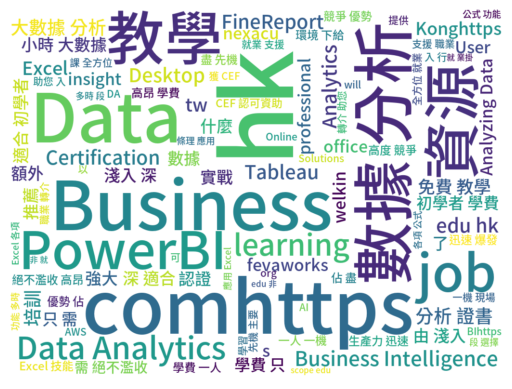

In [23]:
stop_words = list(STOPWORDS)

stop_words += first_search_term.split(' ')

stop_words += ['Course', 'Courses', 'Training', 'Microsoft', 'http', 'https', 'com']
stop_words += ['課程', '香港', '年', '月', '日', '週', '星期', '一天', '一個']
stop_words += ['是', '的', '不', '在', '和', '及', '與', '使用', '可以']
stop_words += ['能', '讓', '有', '我', '人', '你', '您', '上', '於', '但', '嗎', '為']
stop_words += ['一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '翻譯', '這個', '網頁']

font_path = 'NotoSansTC-Medium.otf'

wc = WordCloud(font_path=font_path, background_color="white", width=1024, height=768, 
               max_words=100, max_font_size=200, stopwords=stop_words)

text_list = jieba.cut(" ".join(df_results['Description'].to_list()))
wc.generate(" ".join(text_list))

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

plt.savefig('Word Cloud - ' + first_search_term + '.jpg', bbox_inches='tight')

plt.show()

In [ ]:
keywords_lvl2[-10:]

<h3> Graphs

In [24]:
import seaborn as sns

In [25]:
df = pd.read_excel(r'Scrape results - Power BI Training Hong Kong.xlsx')

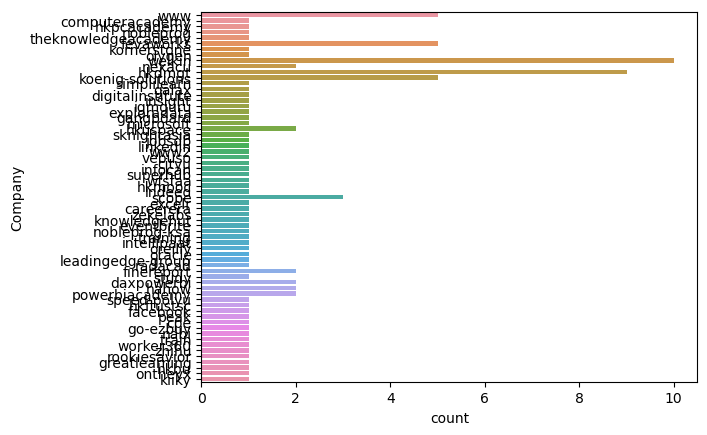

In [26]:
ax = sns.countplot(y="Company", data=df)

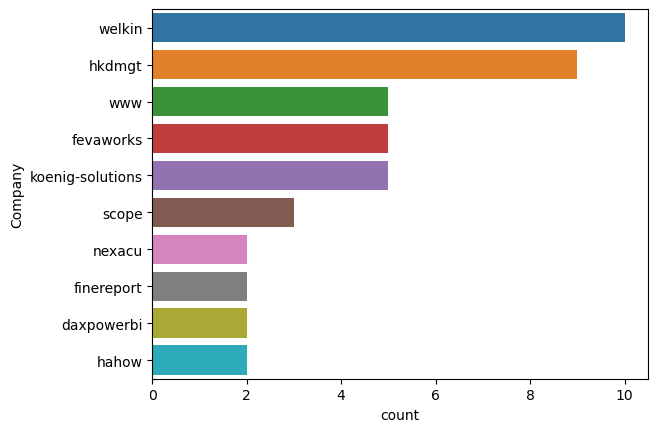

In [27]:
ax = sns.countplot(y="Company", data=df, 
                   order=df.Company.value_counts().iloc[:10].index)

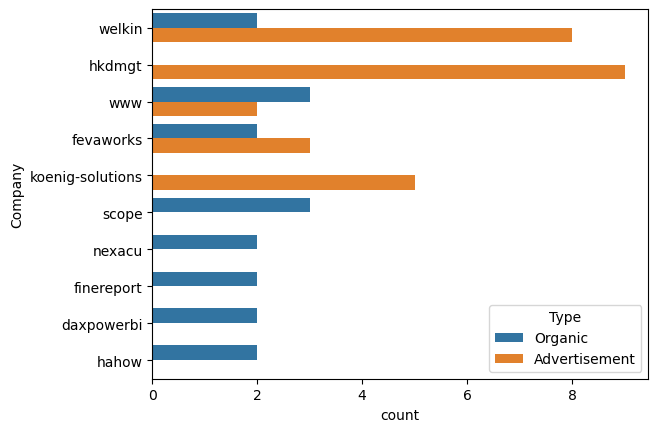

In [28]:
ax = sns.countplot(y="Company", hue="Type", data=df, order=df.Company.value_counts().iloc[:10].index)

In [29]:
len(df)

102

In [30]:
df.drop_duplicates(subset=['Heading', 'Domain'], inplace=True)

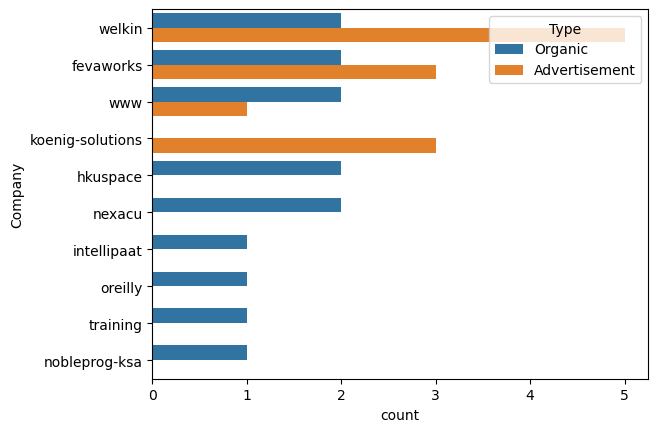

In [31]:
ax = sns.countplot(y="Company", hue="Type", data=df,
                   order=df.Company.value_counts().iloc[:10].index)

In [32]:
df['Type'].value_counts()

Organic          64
Advertisement    17
Name: Type, dtype: int64

<AxesSubplot:ylabel='Type'>

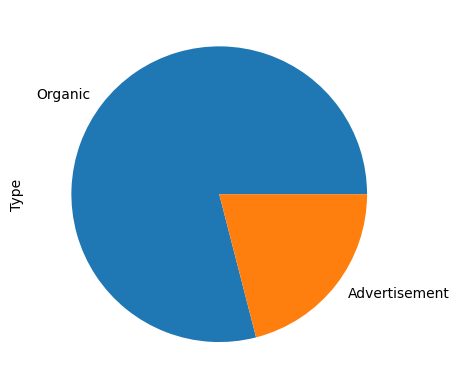

In [33]:
df['Type'].value_counts().plot.pie()

<AxesSubplot:ylabel='Company'>

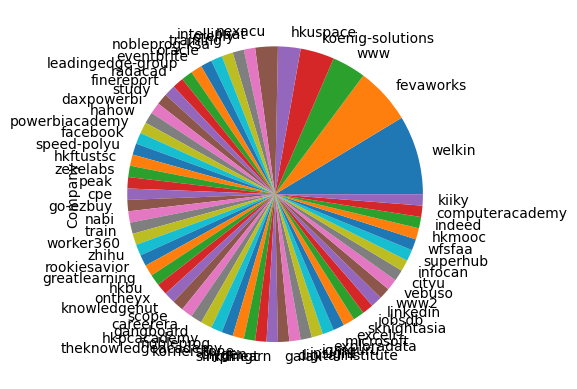

In [34]:
df['Company'].value_counts().plot.pie()

In [35]:
df.Company.value_counts().iloc[:10]

welkin              7
fevaworks           5
www                 3
koenig-solutions    3
hkuspace            2
nexacu              2
intellipaat         1
oreilly             1
training            1
nobleprog-ksa       1
Name: Company, dtype: int64